In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline 

def show(image):
    plt.axis("off")
    if len(image.shape) > 2 and image.shape[2] == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, 'gray')
        
    plt.show()

In [2]:
import os

path = '/home/evaldas/Programming/lines_set/'
pics = os.listdir(path)
print pics
print len(pics)

['IMG_20170302_203448.jpg', 'IMG_20170302_203435.jpg', 'IMG_20170302_203525.jpg', 'IMG_20170302_203534.jpg', 'IMG_20170302_203458.jpg', 'IMG_20170302_203425.jpg', 'IMG_20170302_203520.jpg', 'IMG_20170302_203530.jpg', 'IMG_20170302_203449.jpg', 'IMG_20170302_203510.jpg']
10


In [139]:
import math

def line_func(p1, p2):
    a = float(p2[1] - p1[1]) / (p2[0] - p1[0])
    b = float(p1[1] - a * p1[0])
    
    return a, b

def dist(p1, p2):
    return math.sqrt(pow(p1[0] - p2[0], 2) + pow(p1[1] - p2[1], 2))

def pipeline(image):   
    lower_white = np.array([0,160, 0], dtype=np.uint8)
    upper_white = np.array([100,255, 80], dtype=np.uint8)
    
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    mask = cv2.inRange(hls, lower_white, upper_white)
    res = cv2.bitwise_and(image, image, mask= mask)
    
    hsl_gray = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
    height, width = image.shape[:2]    
    _, contours, _ = cv2.findContours(hsl_gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    correct = []
    edges = []
    
    overlay = image.copy()
    output = image.copy()

    for cnt in contours:
        epsilon = 0.01*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        area = cv2.contourArea(approx)

        if area > 30000:
            continue
            
        x,y,w,h = cv2.boundingRect(cnt)
        
        if w < 180 or h < 100:
            continue
            
        good_pts = []
            
        topmost = approx[approx[:,:,1].argmin()][0]
        bottommost = approx[approx[:,:,1].argmax()][0]
        
        good_pts.append(topmost)
        
        a, b = line_func(topmost, bottommost)
        b_max = 30
        pts = None

        for pt in approx:
            b_temp = pt[0][1] - a * pt[0][0]
            if abs(b - b_temp) > b_max:
                b_max = abs(b - b_temp)
                pts = pt[0]
                
        
        if pts is not None:
            good_pts.append(pts)
            
        good_pts.append(bottommost)
        edges.append(good_pts)
        
        cv2.drawContours(output, [approx], 0, (0,255,0), -1)
        correct.append(approx)
    
    left_crn = np.array([0, height])
    right_crn = np.array([width, height])
    
    road_zone = None
    
    if len(edges) > 1:
        # there is two lines, so robot should stay in between
        p1 = left_crn
        p2 = right_crn
        
        if dist(p2, edges[0][-1]) < dist(p1, edges[0][-1]):
            p1 = right_crn
            p2 = left_crn
            
        pts = [p1]
        for pt in reversed(edges[0]):
            pts.append(pt)
            
        for pt in edges[1]:
            pts.append(pt)
            
        pts.append(p2)
        
        road_zone = np.array(pts)
        cv2.drawContours(overlay, [cnt], 0, (0,255,0), -1)

    # just in case if there was no lines, we should do nothing
    elif len(edges) > 0:
        p1 = left_crn
        p2 = right_crn
        
        if dist(p2, edges[0][-1]) < dist(p1, edges[0][-1]):
            p1 = right_crn
            p2 = left_crn

        add_pt1 = edges[0][0].copy()
        add_pt2 = edges[0][-1].copy()
        add_pt1[0] = 0 if (add_pt1[0] < width / 2) else width
        add_pt2[0] = 0 if (add_pt2[0] < width / 2) else width
        
        edges[0].insert(0, add_pt1)
        edges[0].append(add_pt2)

        pts = [p1]
        for pt in reversed(edges[0]):
            pts.append(pt)
            
        pts.append(p2)
            
        road_zone = np.array(pts)
        
    movement_pts = []
    
    if road_zone is not None:
        cv2.drawContours(overlay, [road_zone], 0, (0,255,0), -1)
        pts = len(road_zone)
        print pts
        if len(edges) > 1:
            for i in range(0, pts / 2):
                center_x = (road_zone[i][0] + road_zone[pts-1-i][0]) / 2
                center_y = (road_zone[i][1] + road_zone[pts-1-i][1]) / 2
                movement_pts.append((center_x, center_y))
                
        else:
            dist1 = dist(road_zone[0], road_zone[1])
            dist2 = dist(road_zone[-1], road_zone[-2])
            
            if dist1 > dist2:
                center_pt = road_zone[0]
            else:
                center_pt = road_zone[-1]
            
            for pt in road_zone:
                if pt[0] == center_pt[0] and pt[1] == center_pt[1]:
                    continue
                center_x = (center_pt[0] + pt[0]) / 2
                center_y = pt[1] / 4 * 5
                if center_y > height:
                    center_y = height
                
                movement_pts.append((center_x, center_y))

    for pt in movement_pts:
        cv2.circle(overlay, pt, 20, (0,0,255), -1)
    cv2.addWeighted(overlay, 0.3, output, 0.7, 0, output)

    return output

7


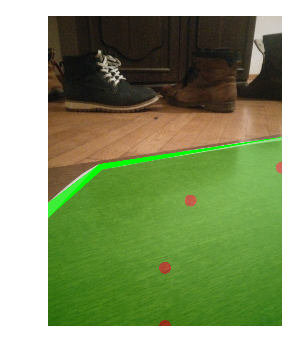

7


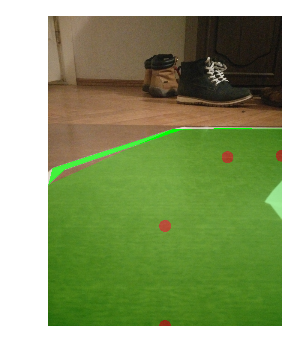

7


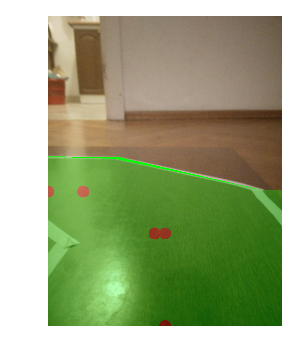

6


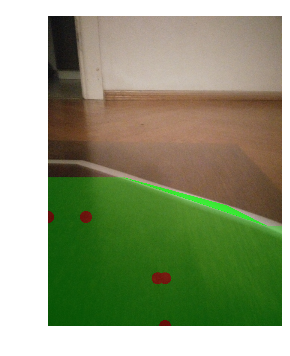

8


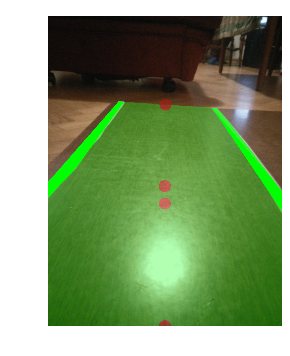

8


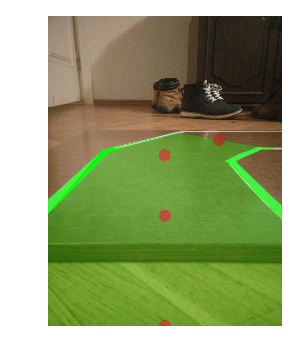

6


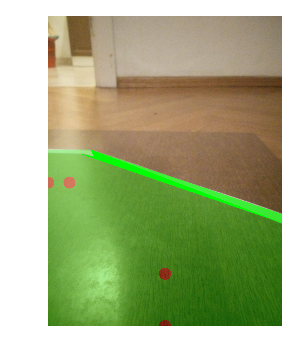

7


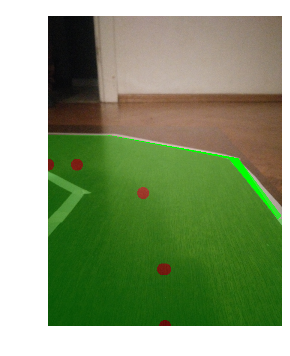

7


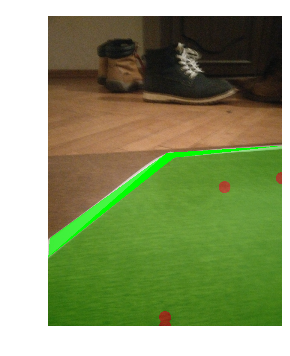

8


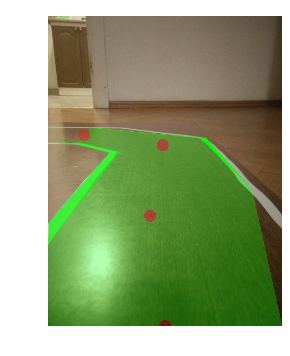

In [140]:
counter = 0
for pic in pics:
    img = cv2.imread(path + pic)
    img = cv2.resize(img, (0,0), fx=0.25, fy=0.25)
    im = pipeline(img)
    show(im)
    counter += 1